In [1]:
from typing import Any
import numpy as np
from numpy import linalg as la

import sys
EPS = sys.float_info.epsilon * 2

def top_k(x, q=0.05): # q - fraction of nonzero elements
    d = x.size
    k = int(np.ceil(d * q))
    
    mask = np.ones(d)
    positions = np.argpartition(np.abs(x), -k)[:-k]
    mask[positions] = 0
    code = mask * x # * d / q

    bits = (x.dtype.itemsize * 8) * k
    bits += min(
        k * np.log2(len(x)), # positions
        (d - k) * np.log2(len(x)), # not positions
        d, # mask
    )
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var

import torch
from MiniFL.compressors import EdenContractiveCompressor

def eden(x, quant, n_bits):
    msg = quant.compress(x)
    code = msg.data

    var = (la.norm(x - code) / la.norm(x))**2
    return code, msg.size, var


from MiniFL.compressors import TopSigmaCompressor
from scipy import integrate

def rot_sigma(x, quant, n_bits):
    msg = quant.compress(x)
    code = msg.data

    var = (la.norm(x - code) / la.norm(x))**2
    return code, msg.size, var

In [2]:
SIZE = 1024
SAMPLER = torch.distributions.laplace.Laplace(0,1)
# SAMPLER = torch.distributions.normal.Normal(0,1)

def sample_vector():
    return SAMPLER.sample((SIZE,)) + torch.ones(SIZE) * 2


In [3]:
from tqdm import tqdm

NUM_REPEAT = 10

eden_variances_mean = []
eden_variances_std = []
eden_bits_mean = []
eden_bits_std = []
for n_bits in tqdm(np.concatenate((
    np.linspace(0.01, 0.4, num=40),
    np.linspace(0.4, 1.99, num=20),    
))):
    quant = EdenContractiveCompressor(size=SIZE, bits=n_bits, real_rotation=False)

    current_variances = np.zeros(NUM_REPEAT)
    current_bits = np.zeros(NUM_REPEAT)

    for i in range(NUM_REPEAT):
        _, bit, var = eden(sample_vector(), quant, n_bits=n_bits)
        current_variances[i] = var
        current_bits[i] = bit / SIZE

    eden_variances_mean.append(np.mean(current_variances))
    eden_variances_std.append(np.std(current_variances) / np.sqrt(NUM_REPEAT - 1))
    eden_bits_mean.append(np.mean(current_bits))
    eden_bits_std.append(np.std(current_bits) / np.sqrt(NUM_REPEAT - 1))

100%|██████████| 60/60 [00:00<00:00, 70.71it/s]


In [4]:
from tqdm import tqdm

NUM_REPEAT = 10

true_eden_variances_mean = []
true_eden_variances_std = []
true_eden_bits_mean = []
true_eden_bits_std = []
for n_bits in tqdm(np.concatenate((
    np.linspace(0.01, 0.4, num=10),
    np.linspace(0.4, 1.99, num=5),    
))):
    quant = EdenContractiveCompressor(size=SIZE, bits=n_bits, real_rotation=True)

    current_variances = np.zeros(NUM_REPEAT)
    current_bits = np.zeros(NUM_REPEAT)

    for i in range(NUM_REPEAT):
        _, bit, var = eden(sample_vector(), quant, n_bits=n_bits)
        current_variances[i] = var
        current_bits[i] = bit / SIZE

    true_eden_variances_mean.append(np.mean(current_variances))
    true_eden_variances_std.append(np.std(current_variances) / np.sqrt(NUM_REPEAT - 1))
    true_eden_bits_mean.append(np.mean(current_bits))
    true_eden_bits_std.append(np.std(current_bits) / np.sqrt(NUM_REPEAT - 1))

 47%|████▋     | 7/15 [00:23<00:46,  5.87s/it]

In [ ]:
BITS = (1,2)

rot_variances_mean = {n_bits: [] for n_bits in BITS}
rot_variances_std = {n_bits: [] for n_bits in BITS}
rot_bits_mean = {n_bits: [] for n_bits in BITS}
rot_bits_std = {n_bits: [] for n_bits in BITS}


for n_bits in BITS:
    for sigmas in tqdm(np.concatenate((
        np.linspace(2, 5, num=30),
        np.linspace(0.1, 2, num=20),
        np.linspace(0.01, 0.1, num=10),
    ))):
        quant = TopSigmaCompressor(size=SIZE, sigmas=sigmas, bits=n_bits, real_rotation=False)

        current_variances = np.zeros(NUM_REPEAT)
        current_bits = np.zeros(NUM_REPEAT)

        for i in range(NUM_REPEAT):
            _, bit, var = rot_sigma(sample_vector(), quant, n_bits)
            current_variances[i] = var
            current_bits[i] = bit / SIZE
        
        rot_variances_mean[n_bits].append(np.mean(current_variances))
        rot_variances_std[n_bits].append(np.std(current_variances) / np.sqrt(NUM_REPEAT - 1))
        rot_bits_mean[n_bits].append(np.mean(current_bits))
        rot_bits_std[n_bits].append(np.std(current_bits) / np.sqrt(NUM_REPEAT - 1))

100%|██████████| 60/60 [00:06<00:00,  9.69it/s]


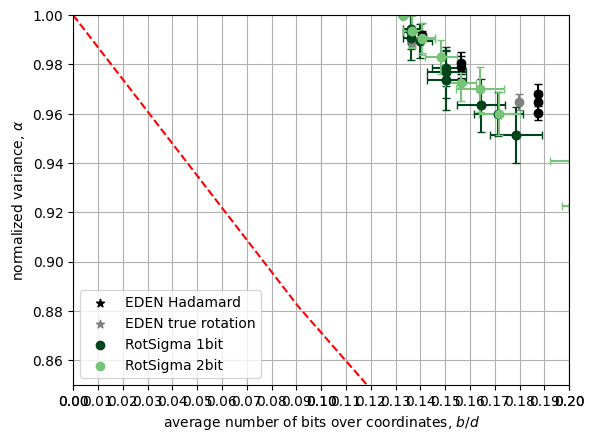

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.scatter(eden_bits_mean, eden_variances_mean, color="black", label="EDEN Hadamard", marker="*")
plt.errorbar(eden_bits_mean, eden_variances_mean, xerr=eden_bits_std, yerr=eden_variances_std, color="black", capsize=3, fmt="o")

plt.scatter(true_eden_bits_mean, true_eden_variances_mean, color="gray", label="EDEN true rotation", marker="*")
plt.errorbar(true_eden_bits_mean, true_eden_variances_mean, xerr=true_eden_bits_std, yerr=true_eden_variances_std, color="gray", capsize=3, fmt="o")

colors = mpl.colormaps["Greens_r"](np.linspace(0, 0.5, len(BITS)))
for n_bits, color in zip(BITS, colors):
    plt.scatter(rot_bits_mean[n_bits], rot_variances_mean[n_bits], color=color, label=f"RotSigma {n_bits}bit")
    plt.errorbar(rot_bits_mean[n_bits], rot_variances_mean[n_bits], xerr=rot_bits_std[n_bits], yerr=rot_variances_std[n_bits], color=color, capsize=3, fmt="o")

x = np.linspace(0, 9, num=100)
y = 4**(-x)
plt.plot(x, y, linestyle="--", color="red")

plt.xticks([i / 100 for i in range(21)] + [i / 10 for i in range(21)])
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 0.2)
plt.ylim(0.85, 1)
plt.show()

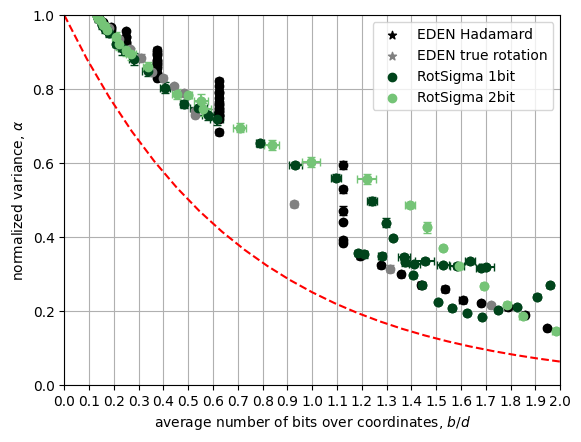

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.scatter(eden_bits_mean, eden_variances_mean, color="black", label="EDEN Hadamard", marker="*")
plt.errorbar(eden_bits_mean, eden_variances_mean, xerr=eden_bits_std, yerr=eden_variances_std, color="black", capsize=3, fmt="o")

plt.scatter(true_eden_bits_mean, true_eden_variances_mean, color="gray", label="EDEN true rotation", marker="*")
plt.errorbar(true_eden_bits_mean, true_eden_variances_mean, xerr=true_eden_bits_std, yerr=true_eden_variances_std, color="gray", capsize=3, fmt="o")

colors = mpl.colormaps["Greens_r"](np.linspace(0, 0.5, len(BITS)))
for n_bits, color in zip(BITS, colors):
    plt.scatter(rot_bits_mean[n_bits], rot_variances_mean[n_bits], color=color, label=f"RotSigma {n_bits}bit")
    plt.errorbar(rot_bits_mean[n_bits], rot_variances_mean[n_bits], xerr=rot_bits_std[n_bits], yerr=rot_variances_std[n_bits], color=color, capsize=3, fmt="o")

x = np.linspace(0, 9, num=100)
y = 4**(-x)
plt.plot(x, y, linestyle="--", color="red")

plt.xticks([i / 10 for i in range(21)])
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.show()

In [ ]:
import math
import scipy

left = SIZE / math.log2(SIZE)
right = SIZE * ( 1 - 1/math.log2(SIZE))

left_bits_per_coord = 1 + left/SIZE + 32 / SIZE
right_bits_per_coord = 1 + right/SIZE + 32 / SIZE

ks_low = np.linspace(1, left, 1000)
BITS_PER_COORD_LOW = ks_low/SIZE + ks_low / SIZE * np.log2(SIZE) + 32 / SIZE

ks_mid = np.linspace(left, right, 1000)
BITS_PER_COORD_MID = 1 + ks_mid/SIZE + 32 / SIZE

ks_high = np.linspace(right, SIZE-1, 1000)
BITS_PER_COORD_HIGH = ks_high/SIZE + (SIZE - ks_high) / SIZE * np.log2(SIZE) + 32 / SIZE

ks = np.concatenate((ks_low, ks_mid, ks_high))

etas = np.sqrt(2) * scipy.special.erfinv(1 - ks/SIZE)

s_var = np.sqrt(2/np.pi) * (np.sqrt(np.pi/2) * scipy.special.erf(etas/np.sqrt(2)) - np.exp(-etas**2 / 2) * etas)
q_var = -2 * np.exp(-etas**2) / (np.pi * scipy.special.erfc(etas/np.sqrt(2))) + scipy.special.erfc(etas/np.sqrt(2)) + np.sqrt(2/np.pi) * np.exp(-etas**2 / 2) * etas

SIGMA_TOTAL_VAR = s_var + q_var
SIGMA_BITS_PER_COORD = np.concatenate((BITS_PER_COORD_LOW, BITS_PER_COORD_MID, BITS_PER_COORD_HIGH))

In [ ]:
import numpy as np
import math
from functools import cache
from MiniFL.compressors.eden import opt_hn_centroids
from scipy.special import erf


def section_variance(a, b, c) -> float:
    if math.isinf(c):
        return np.sqrt(2/np.pi) * np.exp(-a**2/2) * (a - 2*b) - (b**2+1)*erf(a/np.sqrt(2)) + (b**2+1)*erf(c/np.sqrt(2))
    else:
        return np.sqrt(2/np.pi) * np.exp(-a**2/2) * (a - 2*b) - (b**2+1)*erf(a/np.sqrt(2)) + (b**2+1)*erf(c/np.sqrt(2)) + np.sqrt(2/np.pi) * np.exp(-c**2/2) * (2*b - c)

@cache
def bits_var():
    result = {0: 1}
    for bits, centers in opt_hn_centroids.items():
        borders = [0] + [(a + b) / 2 for a, b in zip(centers[:-1], centers[1:])] + [float("inf")]
        variance = sum(section_variance(a, b, c) for a, b, c in zip(borders[:-1], centers, borders[1:]))
        result[bits] = variance
    return result

def eden_alpha(bits):
    vars = bits_var()
    bits_low = np.floor(bits)
    bits_high = bits_low + 1
    return (bits_high - bits) * vars[bits_low] + (bits - bits_low) * vars[bits_high]


bits_per_coord = np.linspace(0, 2, 1000)
alphas = [eden_alpha(bits) for bits in bits_per_coord]

EDEN_TOTAL_VAR = alphas
EDEN_BITS_PER_COORD = bits_per_coord + 32/SIZE

/tmp/ipykernel_675439/92190659.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(true_eden_bits_mean, true_eden_variances_mean, xerr=true_eden_bits_std, yerr=true_eden_variances_std, color="gray", capsize=3, fmt="o", marker="*")


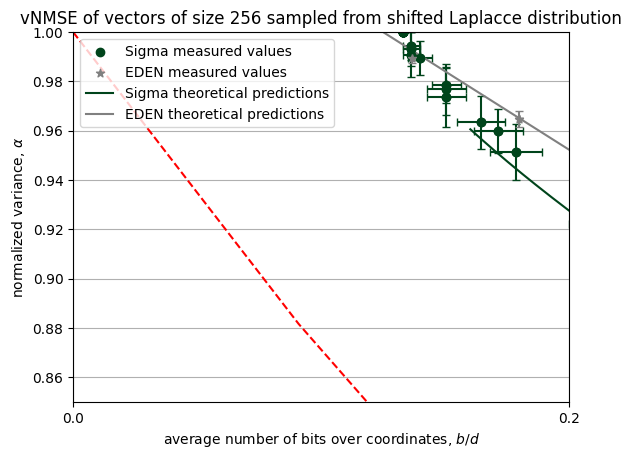

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

colors = mpl.colormaps["Greens_r"](np.linspace(0, 0.5, len(BITS)))

plt.scatter(rot_bits_mean[1], rot_variances_mean[1], color=colors[0], label=f"Sigma measured values")
plt.errorbar(rot_bits_mean[1], rot_variances_mean[1], xerr=rot_bits_std[1], yerr=rot_variances_std[1], color=colors[0], capsize=3, fmt="o")

plt.scatter(true_eden_bits_mean, true_eden_variances_mean, color="gray", label="EDEN measured values", marker="*")
plt.errorbar(true_eden_bits_mean, true_eden_variances_mean, xerr=true_eden_bits_std, yerr=true_eden_variances_std, color="gray", capsize=3, fmt="o", marker="*")

x = np.linspace(0, 9, num=100)
y = 4**(-x)
plt.plot(x, y, linestyle="--", color="red")

plt.axvline(x=left_bits_per_coord, color=colors[0], linestyle="--")
plt.axvline(x=right_bits_per_coord, color=colors[0], linestyle="--")
plt.plot(SIGMA_BITS_PER_COORD, SIGMA_TOTAL_VAR, color=colors[0], label="Sigma theoretical predictions")
plt.plot(EDEN_BITS_PER_COORD, EDEN_TOTAL_VAR, color="gray", label="EDEN theoretical predictions")

plt.xticks([i / 5 for i in range(11)])
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 0.2)
plt.ylim(0.85, 1)
plt.title(f"vNMSE of vectors of size {SIZE} sampled from shifted Laplacce distribution")
plt.show()

/tmp/ipykernel_675439/1539387762.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(true_eden_bits_mean, true_eden_variances_mean, xerr=true_eden_bits_std, yerr=true_eden_variances_std, color="gray", capsize=3, fmt="o", marker="*")


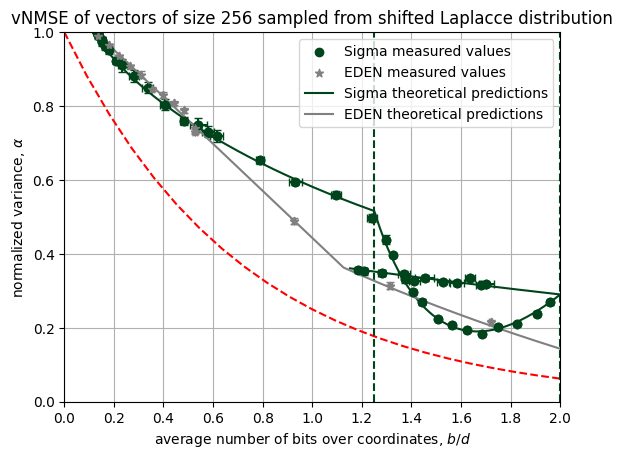

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

colors = mpl.colormaps["Greens_r"](np.linspace(0, 0.5, len(BITS)))

plt.scatter(rot_bits_mean[1], rot_variances_mean[1], color=colors[0], label=f"Sigma measured values")
plt.errorbar(rot_bits_mean[1], rot_variances_mean[1], xerr=rot_bits_std[1], yerr=rot_variances_std[1], color=colors[0], capsize=3, fmt="o")

plt.scatter(true_eden_bits_mean, true_eden_variances_mean, color="gray", label="EDEN measured values", marker="*")
plt.errorbar(true_eden_bits_mean, true_eden_variances_mean, xerr=true_eden_bits_std, yerr=true_eden_variances_std, color="gray", capsize=3, fmt="o", marker="*")

x = np.linspace(0, 9, num=100)
y = 4**(-x)
plt.plot(x, y, linestyle="--", color="red")

plt.axvline(x=left_bits_per_coord, color=colors[0], linestyle="--")
plt.axvline(x=right_bits_per_coord, color=colors[0], linestyle="--")
plt.plot(SIGMA_BITS_PER_COORD, SIGMA_TOTAL_VAR, color=colors[0], label="Sigma theoretical predictions")
plt.plot(EDEN_BITS_PER_COORD, EDEN_TOTAL_VAR, color="gray", label="EDEN theoretical predictions")

plt.xticks([i / 5 for i in range(11)])
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")
plt.legend()
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.title(f"vNMSE of vectors of size {SIZE} sampled from shifted Laplacce distribution")
plt.show()